# Twitter users gender classification

Schloesing Benjamin, Yao Yuan, Ramet Gaétan

## Introduction

The objective of this project is to find features which can help to determine a Twitter user's gender using machine learning.

## Step 1 : Import data

The dataset we will use is the [Twitter User Gender Classification](https://www.kaggle.com/crowdflower/twitter-user-gender-classification) dataset made available by [Crowdflower](https://www.crowdflower.com/). This datasets contains 20000 entries, each of them being a tweet from different users, with many other associated features which are listed here:

* **_unit_id** : a unique id for each user
* **_golden** : a boolean which states whether the user is included in the golden standard for the model
* **_unit_state** : the state of the obervation, eiter *golden* for gold standards or *finalized* for contributor-judged
* **_trusted_judgments** : the number of judgment on a user's gender. 3 for non-golden, or a unique id for golden
* **_last_judgment_at** : date and time of the last judgment, blank for golden observations
* **gender** : either *male*, *female* or *brand* for non-human profiles
* **gender:confidence** : a float representing the confidence of the gender judgment
* **profile_yn** : either *yes* or *no*, *no* meaning that the user's profile was not available when contributors went to judge it
* **created** : date and time of when the profile was created
* **description** : the user's Tweeter profile description
* **fav_number** : the amount of favorited tweets by the user
* **gender_gold** : the gender if the profile is golden
* **link_color** : the link color of the profile as a hex value
* **name** : the Tweeter user's name
* **profile_yn_gold** : *yes* or *no* whether the profile y/n value is golden
* **profileimage** : a link to the profile image
* **retweet_count** : the number of times the user has retweeted something
* **sidebar_color** : color of the profile sidebar as a hex value
* **text** : text of a random tweet from the user
* **tweet_coord** : if the location was available at the time of the tweet, the coordinates as a string ith the format[latitude, longitude]
* **tweet_count** : number of tweet of the users
* **tweet_created** : the time of the random tweet in **text**
* **tweet_id** : the tweet id of the random tweet
* **tweet_location** : the location of the tweet, based on the coordinates
* **user_timezone** : the timezone of the user

Most of these features are not relevant for our analysis, we will only focus on a few of them

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

#graph
from bokeh.plotting import output_notebook, figure, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource

%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

from matplotlib import pyplot as plt
# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

from collections import Counter

import plotly.plotly as py
import plotly.graph_objs as go




# we need latin-1 encoding because there are some special characters (é,...) that do not fit in default UTF-8
dataFrame = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin-1')

#Show a sample of the dataset
dataFrame.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [2]:
print(list(dataFrame))

['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn', 'profile_yn:confidence', 'created', 'description', 'fav_number', 'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage', 'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone']


In [3]:
#feature : 'sidebar_color', 'link_color'
def colorsGraphs(df, feature, genderConfidence = 1, nbToRemove = 1):

    dfCol = df.loc[:,['gender:confidence', 'gender', feature]] #Remove weird values : E+17...
    dfColFiltered = dfCol[(dfCol['gender:confidence'] >= genderConfidence)&((dfCol[feature]).str.contains('E\+') != True)]   
    dfColFilteredMale = dfColFiltered[dfColFiltered['gender'] == 'male']
    dfColFilteredFemale = dfColFiltered[dfColFiltered['gender'] == 'female']
    dfColFilteredBrand = dfColFiltered[dfColFiltered['gender'] == 'brand']
    
    colorMale = dfColFilteredMale[feature]
    colorFemale = dfColFilteredFemale[feature]
    colorBrand = dfColFilteredBrand[feature]
    
    listMale = list(colorMale.values.flatten())
    listFemale = list(colorFemale.values.flatten())
    listBrand = list(colorBrand.values.flatten())
        
    nCommon = 30
    commonFemale = Counter(listFemale).most_common(nCommon)
    commonMale = Counter(listMale).most_common(nCommon)
    commonBrand = Counter(listBrand).most_common(nCommon)
    
    #print(commonBrand[0])
    del commonFemale[0:nbToRemove]
    del commonMale[0:nbToRemove]
    del commonBrand[0:nbToRemove]
    
    colorsFemale = [x[0] for x in commonFemale]
    colorsMale = [x[0] for x in commonMale]
    colorsBrand = [x[0] for x in commonBrand]
    
    colorsNumbFemale = [x[1] for x in commonFemale]
    colorsNumbMale = [x[1] for x in commonMale]
    colorsNumbBrand = [x[1] for x in commonBrand]
    
    colorsHexFemale = ['#' + x + '000000' for x in colorsFemale]
    colorsHexFemale = [x[0:7] for x in colorsHexFemale]
    colorsHexMale = ['#' + x + '000000' for x in colorsMale]
    colorsHexMale = [x[0:7] for x in colorsHexMale]
    colorsHexBrand = ['#' + x + '000000' for x in colorsBrand]
    colorsHexBrand = [x[0:7] for x in colorsHexBrand]
    
    rangeColFemale = list(range(len(colorsFemale)))
    rangeColMale = list(range(len(colorsMale)))
    rangeColBrand = list(range(len(colorsBrand)))
    
    fig1, ax1 = plt.subplots()
    
    bar_width = 0.5
    rects1 = plt.barh(rangeColFemale, colorsNumbFemale, bar_width, label = 'Female', color = colorsHexFemale)
    plt.yticks(rangeColFemale, colorsHexFemale)
    plt.xlabel('Color')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()
    
    fig2, ax2 = plt.subplots()
    
    bar_width = 0.5
    rects1 = plt.barh(rangeColMale, colorsNumbMale, bar_width, label = 'Male', color = colorsHexMale)
    plt.yticks(rangeColMale, colorsHexMale)
    plt.xlabel('Color')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()
    
    
    fig3, ax3 = plt.subplots()
    bar_width = 0.5
    rects1 = plt.barh(rangeColBrand, colorsNumbBrand, bar_width, label = 'Brand', color = colorsHexBrand)
    plt.yticks(rangeColBrand, colorsHexBrand)
    plt.xlabel('Color')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from sklearn import linear_model, metrics

%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage


def compute_bag_of_words(text):
    vectorizer = CountVectorizer()
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

def model_test(model,X_train,y_train,X_test,y_test, full_voc, displayResults = True):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    mse = metrics.mean_squared_error(y_test,y_pred)
    print('mse: {:.4f}'.format(mse))

    W = model.coef_
    print('score: ', model.score(X_test,y_test))
    if(displayResults):
    # Male Predictors 
        print('Best 20 male predictors:')
        idx_male = np.argsort((W[2,:]))
        weight_male_pred = np.zeros(20)
        male_pred_label = ["" for x in range(20)]
        for i in range(20):
            j = idx_male[-1-i]
            weight_male_pred[i] = W[2,j]
            male_pred_label[i] = full_voc[j]
    
        fig1, ax1 = plt.subplots()
    
        bar_width = 0.5
        pred_number = np.arange(20)+1
        rects1 = plt.barh(pred_number,weight_male_pred, bar_width, label = 'Male Predictors', color = '#0084b4')
        plt.yticks(pred_number,male_pred_label)
        plt.xlabel('Predictor')
        plt.ylabel('Weight')
        plt.title('Best 20 male predictors')
        plt.tight_layout()
        plt.show()
    # Male Anti-Predictors    
        print('Best 20 male anti-predictors:')
        idx_male = np.argsort(-(W[2,:]))
        weight_male_antipred = np.zeros(20)
        male_antipred_label = ["" for x in range(20)]
        for i in range(20):
            j = idx_male[-1-i]
            weight_male_antipred[i] = W[2,j]
            male_antipred_label[i] = full_voc[j]
    
        fig2, ax2 = plt.subplots()
    
        bar_width = 0.5
        pred_number = np.arange(20)+1
        rects1 = plt.barh(pred_number,weight_male_antipred, bar_width, label = 'Male Anti-Predictors', color = '#0084b4')
        plt.yticks(pred_number,male_antipred_label)
        plt.xlabel('Anti-Predictor')
        plt.ylabel('Weight')
        plt.title('Best 20 male anti-predictors')
        plt.tight_layout()
        plt.show()
    # Female Predictors    
        print('Best 20 female predictors:')
        idx_female = np.argsort((W[1,:]))
        weight_female_pred = np.zeros(20)
        female_pred_label = ["" for x in range(20)]
        for i in range(20):
            j = idx_female[-1-i]
            weight_female_pred[i] = W[1,j]
            female_pred_label[i] = full_voc[j]
    
        fig3, ax3 = plt.subplots()
    
        bar_width = 0.5
        pred_number = np.arange(20)+1
        rects1 = plt.barh(pred_number,weight_female_pred, bar_width, label = 'Female Predictors', color = '#f5abb5')
        plt.yticks(pred_number,female_pred_label)
        plt.xlabel('Predictor')
        plt.ylabel('Weight')
        plt.title('Best 20 female predictors')
        plt.tight_layout()
        plt.show()
    # Female Anti-Predictors    
        print('Best 20 female anti-predictors:')
        idx_female = np.argsort(-(W[1,:]))
        weight_female_antipred = np.zeros(20)
        female_antipred_label = ["" for x in range(20)]
        for i in range(20):
            j = idx_female[-1-i]
            weight_female_antipred[i] = W[1,j]
            female_antipred_label[i] = full_voc[j]
    
        fig4, ax4 = plt.subplots()
    
        bar_width = 0.5
        pred_number = np.arange(20)+1
        rects1 = plt.barh(pred_number,weight_female_antipred, bar_width, label = 'Female Anti-Predictors', color = '#f5abb5')
        plt.yticks(pred_number,female_antipred_label)
        plt.xlabel('Anti-Predictor')
        plt.ylabel('Weight')
        plt.title('Best 20 female anti-predictors')
        plt.tight_layout()
        plt.show()
    # Brand Predictors    
        print('Best 20 brand predictors:')
        idx_brand = np.argsort((W[0,:]))
        weight_brand_pred = np.zeros(20)
        brand_pred_label = ["" for x in range(20)]
        for i in range(20):
            j = idx_brand[-1-i]
            weight_brand_pred[i] = W[0,j]
            brand_pred_label[i] = full_voc[j]
    
        fig5, ax5 = plt.subplots()
    
        bar_width = 0.5
        pred_number = np.arange(20)+1
        rects1 = plt.barh(pred_number,weight_brand_pred, bar_width, label = 'Brand Predictors', color = '#4a913c')
        plt.yticks(pred_number,brand_pred_label)
        plt.xlabel('Predictor')
        plt.ylabel('Weight')
        plt.title('Best 20 brand predictors')
        plt.tight_layout()
        plt.show()
    # Brand Anti-Predictors    
        print('Best 20 brand anti-predictors:')
        idx_brand = np.argsort(-(W[0,:]))
        weight_brand_antipred = np.zeros(20)
        brand_antipred_label = ["" for x in range(20)]
        for i in range(20):
            j = idx_brand[-1-i]
            weight_brand_antipred[i] = W[0,j]
            brand_antipred_label[i] = full_voc[j]
    
        fig6, ax6 = plt.subplots()
    
        bar_width = 0.5
        pred_number = np.arange(20)+1
        rects1 = plt.barh(pred_number,weight_brand_antipred, bar_width, label = 'Brand Anti-Predictors', color = '#4a913c')
        plt.yticks(pred_number,brand_antipred_label)
        plt.xlabel('Anti-Predictor')
        plt.ylabel('Weight')
        plt.title('Best 20 brand anti-predictors')
        plt.tight_layout()
        plt.show()
    

#feature is a string in order to use df[feature]
# model = linear_model.RidgeClassifier()
# model = linear_model.SGDClassifier()
# model = linear_model.LogisticRegression()
def predictors(df, feature, model, modelname, displayResults = True):
    print('Testing ', modelname)
    full_bow, full_voc = compute_bag_of_words(df[feature])
    X = full_bow
    y = LabelEncoder().fit_transform(df['gender'])
    # Create Training and testing sets.
    n,d = X.shape
    test_size = n // 5
    print('Split: {} testing and {} training samples'.format(test_size, y.size - test_size))
    perm = np.random.permutation(y.size)
    X_test  = X[perm[:test_size]]
    X_train = X[perm[test_size:]]
    y_test  = y[perm[:test_size]]
    y_train = y[perm[test_size:]]
    print('model: ', modelname)
    model_test(model,X_train,y_train,X_test,y_test, full_voc, displayResults = displayResults)

<IPython.core.display.Javascript object>


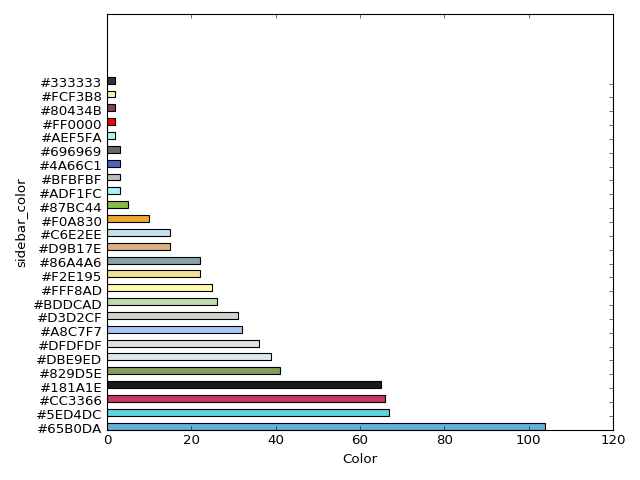

<IPython.core.display.Javascript object>


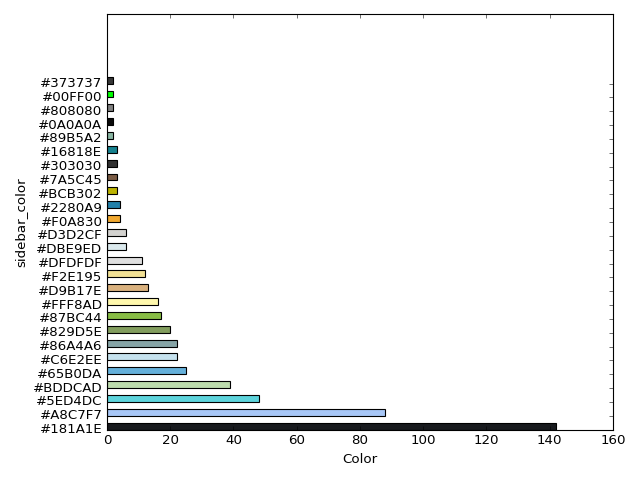

<IPython.core.display.Javascript object>


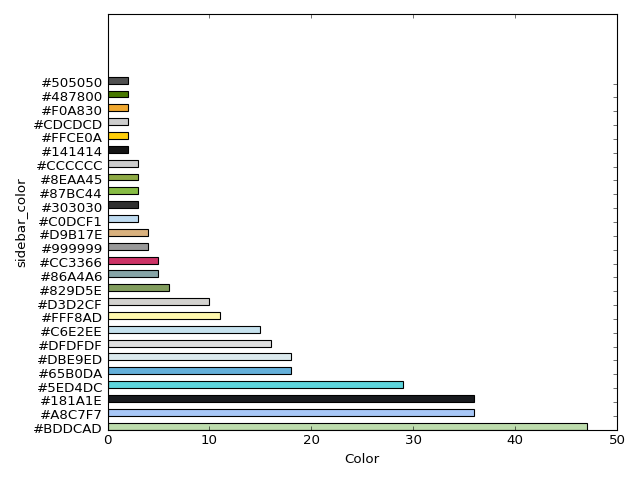

<IPython.core.display.Javascript object>


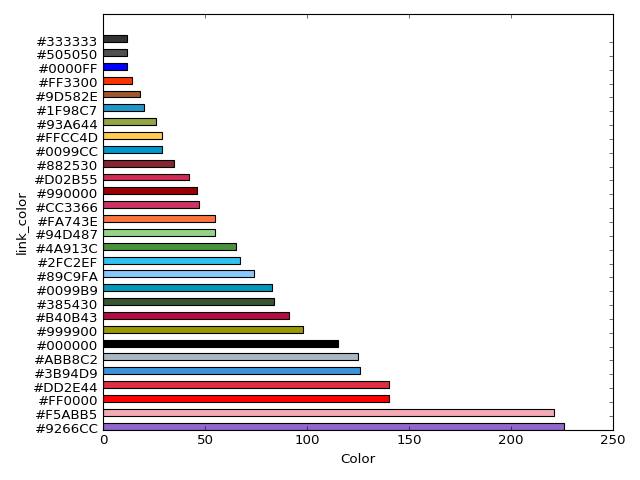

<IPython.core.display.Javascript object>


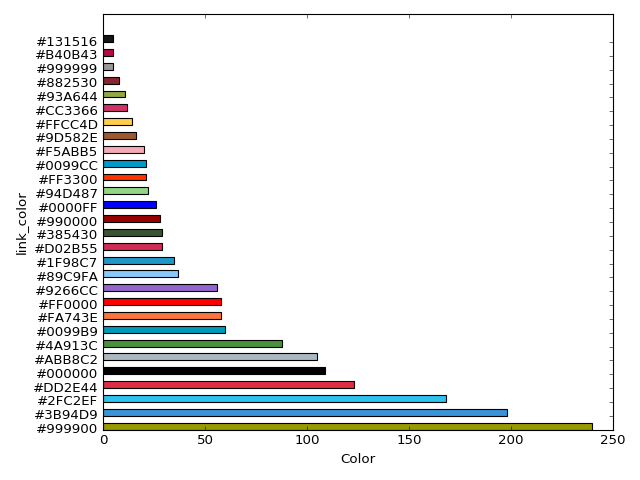

<IPython.core.display.Javascript object>


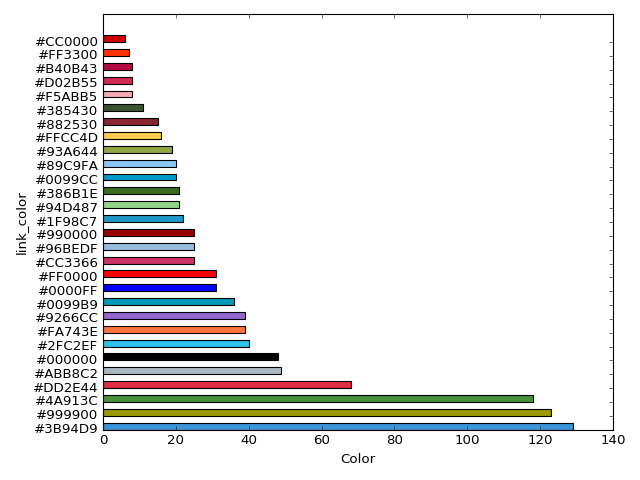

In [8]:
colorsGraphs(dataFrame, 'sidebar_color', 1, 4)
colorsGraphs(dataFrame, 'link_color', 1, 1)

In [7]:
#Through Classifier

dataFrameColor = dataFrame.loc[:,['gender:confidence', 'gender', 'link_color']]
dataFrameColorFiltered = dataFrameColor[(dataFrameColor['gender:confidence'] == 1)&(dataFrameColor['link_color'].str.contains('E\+') != True)]

feature = 'link_color'
df = dataFrameColorFiltered

#dataFrameLinkColFiltered2['link_color']
#print('Testing Ridge Classifier model:')

modelList = [linear_model.RidgeClassifier(), linear_model.SGDClassifier(), linear_model.LogisticRegression(),linear_model.PassiveAggressiveClassifier()]
modelNamesList = ['Ridge Classifier model', 'SGD Classifier', 'Logistic regression', 'Passive Aggressive Classifier']
# model = linear_model.PassiveAggressiveClassifier()
# modelname = 'Ridge Classifier model'
for i in range(0, len(modelList)):
    model = modelList[i]
    modelName = modelNamesList[i]
    predictors(df, feature, model, modelName, displayResults = False)



Testing  Ridge Classifier model
Split: 2780 testing and 11120 training samples
model:  Ridge Classifier model
mse: 1.1514
score:  0.43309352518
Testing  SGD Classifier
Split: 2780 testing and 11120 training samples
model:  SGD Classifier
mse: 1.1705
score:  0.428057553957
Testing  Logistic regression
Split: 2780 testing and 11120 training samples
model:  Logistic regression
mse: 1.1227
score:  0.438489208633
Testing  Passive Aggressive Classifier
Split: 2780 testing and 11120 training samples
model:  Passive Aggressive Classifier
mse: 0.8014
score:  0.403597122302


In [ ]:
#Get profile pictures, to have it big just remove '_normal'
pd.options.display.max_colwidth = 100
print(dataFrame.loc[1, 'profileimage'])

from PIL import Image 
from io import BytesIO
import requests

url = dataFrame.loc[1, 'profileimage']
response = requests.get(url)
img = Image.open(BytesIO(response.content))
print(img.format)  # 'JPEG'